In [1]:
devtools::load_all('~/src/mcATAC/')

ℹ Loading mcATAC



In [2]:
devtools::load_all('~/src/misha.ext/')
pmc = readRDS('~/raid/proj/mmcortex/data/pl_cort_peak_mc_smoothed_mg.rds')
pmc_rn = convert_10x_peak_names_to_misha_intervals(rownames(pmc))

ℹ Loading misha.ext



In [3]:
library(metacell)

### Test interval annotation

In [48]:
annotate_intervals <- function(intervals, MIN_PROXIMAL = 1e+03, MAX_PROXIMAL = 2e+04, MIN_DISTAL = 2e+04, MAX_DISTAL = 1e+06, EXONIC_PEAK_DIST = 0) {
    # TODO: update peak annotation data frame with neighbor gene, distance, more (exons, enhancers etc.). The annotation might be an optional paramter.

    # TODO: check whether a genome is loaded
    # TODO: check whether 'tss' and 'exons' interval sets are already loaded
    
    gsetroot('/home/aviezerl/mm10')
    tss = gintervals.load('tss')
    exons = gintervals.load('exons')
    kgid_both = intersect(unique(exons$kgID), unique(tss$kgID))
    exons_filt = exons[exons$kgID %in% kgid_both,]
    genes_start = tapply(exons_filt$start, exons_filt$kgID, min)
    genes_end = tapply(exons_filt$end, exons_filt$kgID, max)
    gene_body_df = as.data.frame(do.call('cbind', 
                                        list('chrom' = as.character(exons_filt$chrom)[match(names(genes_start), exons_filt$kgID)], 
                                            'start' = genes_start,
                                            'end' = genes_end,
                                            'strand' = exons_filt$strand[match(names(genes_start), exons_filt$kgID)],
                                            'mRNA' = exons_filt$mRNA[match(names(genes_start), exons_filt$kgID)],
                                            'geneSymbol' = exons_filt$geneSymbol[match(names(genes_start), exons_filt$kgID)])
                                        )) 
    gene_body_df[,2:4] = apply(gene_body_df[,2:4], 2, as.numeric) 
    gene_body_df = gene_body_df[with(gene_body_df, order(chrom, start)),]
    if (length(grep('intervalID', colnames(intervals))) == 0) {intervals$intervalID = 1:nrow(intervals)}
    nei_peak_prom = gintervals.neighbors(intervals, tss, mindist = -MIN_PROXIMAL, maxdist = MIN_PROXIMAL)
    nei_peak_exon = gintervals.neighbors(intervals, exons, mindist = -EXONIC_PEAK_DIST, maxdist = EXONIC_PEAK_DIST)
    nei_peak_gb = gintervals.neighbors(intervals, gene_body_df, maxdist = 0, mindist = 0)
    prom_peaks = nei_peak_prom$intervalID
    exon_peaks = nei_peak_exon$intervalID[!(nei_peak_exon$intervalID %in% prom_peaks)]
    intron_peaks = nei_peak_gb$intervalID[!(nei_peak_gb$intervalID %in% union(exon_peaks, prom_peaks))]
    intID_left = intervals$intervalID[!(intervals$intervalID %in% union(prom_peaks, union(exon_peaks, intron_peaks)))]
    nei_peak_tss_prox = gintervals.neighbors(intervals[intervals$intervalID %in% intID_left,], tss, mindist = MIN_PROXIMAL, maxdist = MAX_PROXIMAL)
    nei_peak_tss_prox_neg = gintervals.neighbors(intervals[intervals$intervalID %in% intID_left,], tss, maxdist = -MIN_PROXIMAL, mindist = -MAX_PROXIMAL)
    nei_peak_prox_all = dplyr::anti_join(unique(rbind(nei_peak_tss_prox[,1:4], nei_peak_tss_prox_neg[,1:4])), 
        intervals[union(prom_peaks, union(exon_peaks, intron_peaks)),1:4], by = c('chrom', 'start', 'end', 'intervalID'))
    ig_prox_peaks = nei_peak_prox_all$intervalID
    intID_left = intervals$intervalID[!(intervals$intervalID %in% unique(c(prom_peaks, exon_peaks, intron_peaks, ig_prox_peaks)))]
    nei_peak_dist = gintervals.neighbors(intervals[intervals$intervalID %in% intID_left,], tss, mindist = MIN_DISTAL, maxdist = MAX_DISTAL)
    nei_peak_dist_neg = gintervals.neighbors(intervals[intervals$intervalID %in% intID_left,], tss, maxdist = -MIN_DISTAL, mindist = -MAX_DISTAL)
    nei_peak_dist_all = dplyr::anti_join(unique(rbind(nei_peak_dist[,1:4], nei_peak_dist_neg[,1:4])), 
        intervals[union(ig_prox_peaks, union(prom_peaks, union(exon_peaks, intron_peaks))),1:4], by = c('chrom', 'start', 'end', 'intervalID'))
    ig_dist_peaks = nei_peak_dist_all$intervalID
    desert_peaks = intervals$intervalID[!(intervals$intervalID %in% 
                                    unique(c(prom_peaks, exon_peaks, intron_peaks, ig_prox_peaks, ig_dist_peaks)))]
    res = c(setNames(rep('promoter', length(prom_peaks)), prom_peaks),
            setNames(rep('exonic', length(exon_peaks)), exon_peaks),
            setNames(rep('intronic', length(intron_peaks)), intron_peaks),
            setNames(rep('ig_proximal', length(ig_prox_peaks)), ig_prox_peaks),
            setNames(rep('ig_distal', length(ig_dist_peaks)), ig_dist_peaks),
            setNames(rep('desert', length(desert_peaks)), desert_peaks)
    )
    intervals$peak_annot = res[order(as.numeric(names(res)))]
    return(intervals)
}





ap = annotate_intervals(pmc_rn)

tss = gintervals.load('tss')

subset(tss, subset = chrom == 'chr1' & start >= 4.4e+6 & end <= 4.5e+6)

head(ap, 60)

uu = unique(ap)
inter_mat = matrix(0, length(uu), length(uu))
colnames(inter_mat) = uu
rownames(inter_mat) = colnames(inter_mat)
for (i in 1:length(uu)) {
    for (j in i:length(uu)) {
        inter_mat[i,j] = length(intersect(as.numeric(names(ap))[ap == uu[[i]]], as.numeric(names(ap))[ap == uu[[j]]]))
    }
}

inter_mat

sum(inter_mat)

### Test ATAC metacell projection

In [18]:
wd = '~/raid/proj//embenh'
setwd(wd)
scdb_init('./scdb')


initializing scdb to ./scdb



In [21]:
# cells_both = intersect(colnames(atac$mat), names(mc@mc))
# atac_mat_filt = as.matrix(atac$mat[,cells_both])
# mc_filt = mc@mc[names(mc@mc) %in% cells_both]
# mc_filt = mc_filt[cells_both]
# print(class(atac_mat_filt))
# mc_atac = tgs_matrix_tapply(t(atac_mat_filt), mc_filt, mean)

In [22]:
atac_mat = scdb_mat('atac_all')

In [23]:
dim(atac_mat@mat)

[1] 130254   7960

In [24]:
scatac = ScATAC(atac_mat@mat, peaks = convert_10x_peak_names_to_misha_intervals(rownames(atac_mat@mat)))

In [25]:
mc = scdb_mc('rna_all')

In [26]:
head(mc@mc)

AAACAGCCAAGGTACG-1-sm AAACAGCCACAGACTC-1-sm AAACAGCCATGACTAT-1-sm 
                   62                    14                    20 
AAACCAACAAGGTATA-1-sm AAACCAACATCAGTAT-1-sm AAACCGAAGGTCGAGG-1-sm 
                   69                     2                    52

In [29]:
cell_to_metacell = as.data.frame(list('cell_id' = names(mc@mc), 'metacell' = mc@mc))

In [82]:
head(cell_to_metacell)

,cell_id,metacell
,<chr>,<int>
AAACAGCCAAGGTACG-1-sm,AAACAGCCAAGGTACG-1-sm,62
AAACAGCCACAGACTC-1-sm,AAACAGCCACAGACTC-1-sm,14
AAACAGCCATGACTAT-1-sm,AAACAGCCATGACTAT-1-sm,20
AAACCAACAAGGTATA-1-sm,AAACCAACAAGGTATA-1-sm,69
AAACCAACATCAGTAT-1-sm,AAACCAACATCAGTAT-1-sm,2
AAACCGAAGGTCGAGG-1-sm,AAACCGAAGGTCGAGG-1-sm,52


In [53]:
rm(project_atac_on_mc)

In [30]:
project_atac_on_mc <- function(atac, mc = NULL, cell_to_metacell = NULL, MIN_INT_FRAC = 0.1) {
    if (!is.null(mc) && is.null(cell_to_metacell)) {
        cells_both = intersect(colnames(atac$mat), names(mc@mc))
        mc_filt = mc@mc[names(mc@mc) %in% cells_both]
    }
    if (is.null(mc) && !is.null(cell_to_metacell)) {
        cells_both = intersect(colnames(atac$mat), cell_to_metacell$cell_id)
        c2m_ord = cell_to_metacell[match(cells_both, cell_to_metacell$cell_id),]
        mc_filt = setNames(c2m_ord$metacell, c2m_ord$cell_id)
    }
    if (length(cells_both) <= round(0.1*length(colnames(atac$mat)))) {
                warning(glue::glue('Intersect of ATAC mat colnames and mc names is less than {round(100*MIN_INT_FRAC, 2)}%. Make sure you are projecting the right objects.'))
            }
    atac_mat_filt = as.matrix(atac$mat[,cells_both])
    mc_filt = mc_filt[cells_both]
    mc_atac = tgs_matrix_tapply(atac_mat_filt, mc_filt, mean)
    return(t(mc_atac))
}

In [31]:
mc_proj1 = project_atac_on_mc(scatac, mc = mc)

In [32]:
mc_proj2 = project_atac_on_mc(scatac, cell_to_metacell = cell_to_metacell)

In [33]:
dim(mc_proj1)

[1] 130254     74

In [34]:
dim(mc_proj2)

[1] 130254     74

In [35]:
head(mc_proj1)

,1,2,3,4,5,6,7,8,9,10,⋯,65,66,67,68,69,70,71,72,73,74
chr1:3035431-3036341,0.019047619,0.02272727,0.04000000,0.07874016,0.05825243,0.3137255,0.05357143,0.02702703,0.09333333,0.11475410,⋯,0.12345679,0.08988764,0.04958678,0.04444444,0.07258065,0.07377049,0.0250,0.10000000,0.16279070,0.11494253
chr1:3062463-3063361,0.004761905,0.21212121,0.14666667,0.33858268,0.27184466,0.7450980,0.16964286,0.00000000,0.22666667,0.18852459,⋯,0.79012346,0.47191011,0.74380165,0.36666667,0.82258065,0.31147541,0.4000,0.56363636,0.69767442,0.39080460
chr1:3191391-3192285,0.052380952,0.34090909,0.24000000,0.59842520,0.58252427,1.5294118,0.39285714,0.48648649,0.69333333,0.99180328,⋯,0.77777778,0.49438202,1.04958678,0.66666667,0.74193548,0.50000000,0.6125,0.62727273,0.95348837,0.62068966
chr1:3399772-3400665,0.171428571,0.81060606,1.45333333,1.95275591,1.92233010,4.3431373,1.14285714,1.14864865,2.26666667,2.22131148,⋯,2.45679012,1.16853933,2.38016529,1.18888889,2.09677419,1.77049180,1.5000,2.12727273,3.05813953,1.66666667
chr1:3482705-3483610,0.000000000,0.00000000,0.02666667,0.00000000,0.03883495,0.1470588,0.03571429,0.01351351,0.06666667,0.00000000,⋯,0.07407407,0.00000000,0.04958678,0.02222222,0.03225806,0.00000000,0.0000,0.01818182,0.02325581,0.02298851
chr1:3549123-3550041,0.014285714,0.01515152,0.01333333,0.00000000,0.01941748,0.1372549,0.02678571,0.02702703,0.08000000,0.01639344,⋯,0.07407407,0.02247191,0.08264463,0.00000000,0.08870968,0.02459016,0.0000,0.06363636,0.02325581,0.02298851


In [36]:
head(mc_proj2)

,1,2,3,4,5,6,7,8,9,10,⋯,65,66,67,68,69,70,71,72,73,74
chr1:3035431-3036341,0.019047619,0.02272727,0.04000000,0.07874016,0.05825243,0.3137255,0.05357143,0.02702703,0.09333333,0.11475410,⋯,0.12345679,0.08988764,0.04958678,0.04444444,0.07258065,0.07377049,0.0250,0.10000000,0.16279070,0.11494253
chr1:3062463-3063361,0.004761905,0.21212121,0.14666667,0.33858268,0.27184466,0.7450980,0.16964286,0.00000000,0.22666667,0.18852459,⋯,0.79012346,0.47191011,0.74380165,0.36666667,0.82258065,0.31147541,0.4000,0.56363636,0.69767442,0.39080460
chr1:3191391-3192285,0.052380952,0.34090909,0.24000000,0.59842520,0.58252427,1.5294118,0.39285714,0.48648649,0.69333333,0.99180328,⋯,0.77777778,0.49438202,1.04958678,0.66666667,0.74193548,0.50000000,0.6125,0.62727273,0.95348837,0.62068966
chr1:3399772-3400665,0.171428571,0.81060606,1.45333333,1.95275591,1.92233010,4.3431373,1.14285714,1.14864865,2.26666667,2.22131148,⋯,2.45679012,1.16853933,2.38016529,1.18888889,2.09677419,1.77049180,1.5000,2.12727273,3.05813953,1.66666667
chr1:3482705-3483610,0.000000000,0.00000000,0.02666667,0.00000000,0.03883495,0.1470588,0.03571429,0.01351351,0.06666667,0.00000000,⋯,0.07407407,0.00000000,0.04958678,0.02222222,0.03225806,0.00000000,0.0000,0.01818182,0.02325581,0.02298851
chr1:3549123-3550041,0.014285714,0.01515152,0.01333333,0.00000000,0.01941748,0.1372549,0.02678571,0.02702703,0.08000000,0.01639344,⋯,0.07407407,0.02247191,0.08264463,0.00000000,0.08870968,0.02459016,0.0000,0.06363636,0.02325581,0.02298851


### Test export functions

In [36]:
devtools::load_all('~/src/mcATAC/')

ℹ Loading mcATAC



In [4]:
setwd('~/raid/proj/mmcortex')

In [5]:
mcmd = readr::read_tsv('./BonevCollab/mcmd_pl_cort.tsv')

Rows: 454 Columns: 11
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): st, color
dbl (9): mc, E13, E14, E15, E16, E17, E18, mean_day, time_bin

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
dim(pmc)

[1] 98905   454

In [44]:
dir.create('./data/test_ucsc_export/')

In [9]:
colnames(pmc) = 1:ncol(pmc)

mcatac = McATAC(mat = pmc, peaks = convert_10x_peak_names_to_misha_intervals(rownames(pmc)), metadata = dplyr::rename(mcmd[,c('mc', 'st', 'color')], metacell = mc, cell_type = st))

In [77]:
devtools::load_all('~/src/mcATAC/')

ℹ Loading mcATAC



In [73]:
gset_genome('mm10')

In [78]:
export_atac_clust_misha(mc_atac = mcatac, track_prefix = 'test_mmcortex', normalization = 'lfcom')

[1] "lfcom"


In [96]:
gdb.reload()

In [95]:
gtrack.ls('test_mmcortex')

character(0)

In [81]:
stuff = gextract(gtrack.ls('test_mmcortex'), intervals = ALLGENOME[[1]][1:2,], colnames = gsub('test_mmcortex_', '', gtrack.ls('test_mmcortex')), iterator = 1e+4)

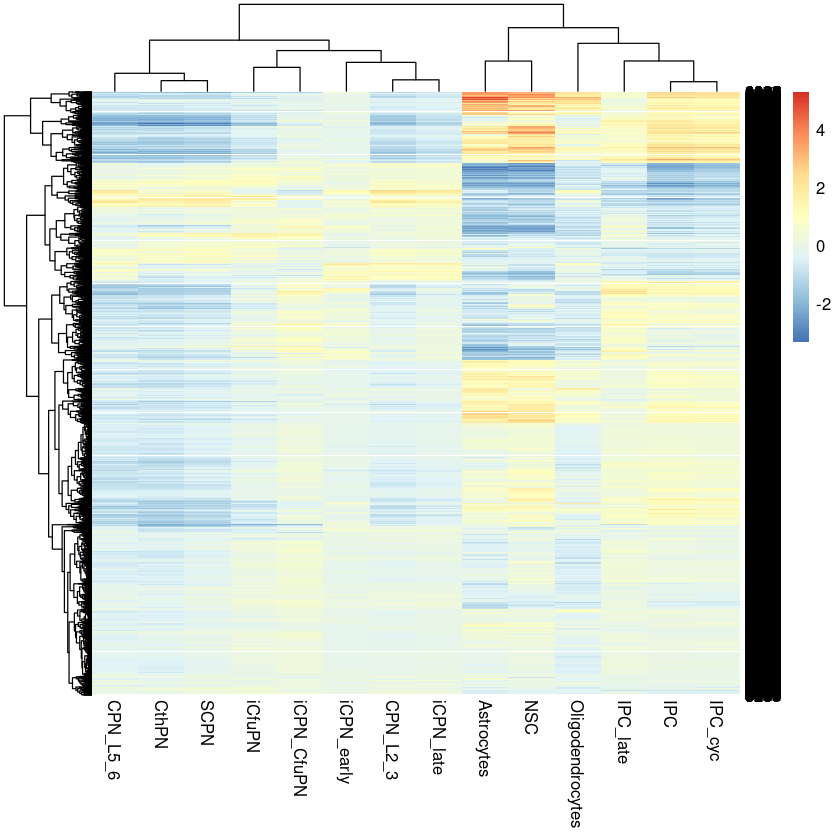

In [85]:
pheatmap::pheatmap(tidyr::drop_na(stuff)[,-c(1:3, ncol(stuff))])

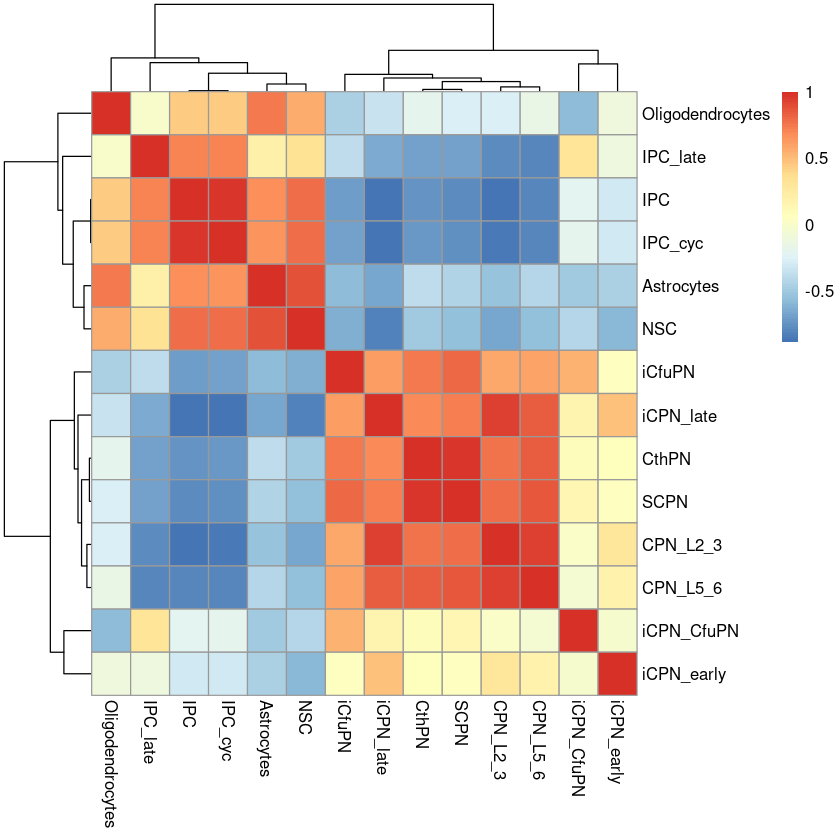

In [90]:
pp = pheatmap::pheatmap(tgs_cor(as.matrix(tidyr::drop_na(stuff)[,-c(1:3, ncol(stuff))]), spearman = T))

In [91]:
tgs_cor(as.matrix(tidyr::drop_na(stuff)[,-c(1:3, ncol(stuff))]), spearman = T)[pp$tree_col$order,pp$tree_col$order]

,Oligodendrocytes,IPC_late,IPC,IPC_cyc,Astrocytes,NSC,iCfuPN,iCPN_late,CthPN,SCPN,CPN_L2_3,CPN_L5_6,iCPN_CfuPN,iCPN_early
Oligodendrocytes,1.00000000,-0.01098145,0.4411994,0.4388315,0.7448625,0.5551699,-0.46216509,-0.3548305,-0.20435818,-0.26918890,-0.265532457,-0.16834819,-0.582461161,-0.10918349
IPC_late,-0.01098145,1.00000000,0.7083585,0.7159214,0.1880522,0.3335770,-0.39722679,-0.6595599,-0.69924315,-0.69530552,-0.777224256,-0.80275470,0.310628436,-0.11936277
IPC,0.44119937,0.70835849,1.0000000,0.9744123,0.6697925,0.7911696,-0.71398677,-0.8887438,-0.74772588,-0.78821327,-0.871589567,-0.81205009,-0.226917566,-0.31049923
IPC_cyc,0.43883146,0.71592137,0.9744123,1.0000000,0.6542605,0.7833174,-0.68857032,-0.8747343,-0.72782893,-0.77303345,-0.862018738,-0.79755281,-0.203804063,-0.31102951
Astrocytes,0.74486251,0.18805223,0.6697925,0.6542605,1.0000000,0.8689324,-0.57827837,-0.6774894,-0.39631079,-0.44658823,-0.539289949,-0.42777828,-0.505796332,-0.46064256
NSC,0.55516994,0.33357702,0.7911696,0.7833174,0.8689324,1.0000000,-0.62919472,-0.8240829,-0.50897408,-0.55494473,-0.676899176,-0.56597111,-0.427525880,-0.59666576
iCfuPN,-0.46216509,-0.39722679,-0.7139868,-0.6885703,-0.5782784,-0.6291947,1.00000000,0.6120489,0.75344560,0.79442203,0.576872978,0.59027953,0.542878604,0.05258467
iCPN_late,-0.35483047,-0.65955990,-0.8887438,-0.8747343,-0.6774894,-0.8240829,0.61204888,1.0000000,0.68606900,0.71935251,0.932950635,0.83571221,0.150637217,0.48668580
CthPN,-0.20435818,-0.69924315,-0.7477259,-0.7278289,-0.3963108,-0.5089741,0.75344560,0.6860690,1.00000000,0.97358957,0.759443063,0.84407470,0.089209073,0.05820061
SCPN,-0.26918890,-0.69530552,-0.7882133,-0.7730334,-0.4465882,-0.5549447,0.79442203,0.7193525,0.97358957,1.00000000,0.785885324,0.84922355,0.141141814,0.05058369


### Test clustering

In [114]:
devtools::load_all('~/src/mcATAC/')

ℹ Loading mcATAC



In [115]:
am_km = gen_atac_mc_clust(mcatac, k = 14, use_prior_annot = F)

# A tibble: 6 × 1
  cell_type 
  <chr>     
1 Astrocytes
2 Astrocytes
3 NSC       
4 Astrocytes
5 NSC       
6 Astrocytes


Warning message in TGL_kmeans_tidy(df = df, k = k, metric = metric, max_iter = max_iter, :
“Input doesn't have a column named "id". Using rownames instead.”


In [116]:
## use_prior_annot == F
am_km

1     2     3     4     5     6     7     8     9    10    11    12    13 
   13    12    13     1    13    13     6    13     3    14     9     3    13 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
   13    13     3     3     3    13    13    13    13    14     8    13    13 
   27    28    29    30    31    32    33    34    35    36    37    38    39 
   13    13    13     9     9    14    11    13     7     7     3    14    14 
   40    41    42    43    44    45    46    47    48    49    50    51    52 
   12     4     5     6    13     8    13    13    13     4     3     9    14 
   53    54    55    56    57    58    59    60    61    62    63    64    65 
   13    13    13     4     8    14     3    13    13    12     7     3     7 
   66    67    68    69    70    71    72    73    74    75    76    77    78 
    3     7     3    13    13    13     3    14    10     8     3    13     3 
   79    80    81    82    83    84    85    86    87    88    89    90    91 
   13    13    14    10    14    13    13    13    13    13     1     2     3 
   92    93    94    95    96    97    98    99   100   101   102   103   104 
   11    14     6    13    13     7     3     3     4    13    12     3     4 
  105   106   107   108   109   110   111   112   113   114   115   116   117 
    5     6    13    13     3    13     9    14    10    13    14     9     4 
  118   119   120   121   122   123   124   125   126   127   128   129   130 
   14     4     9    14     9    13    14     9    13     1    13    13    13 
  131   132   133   134   135   136   137   138   139   140   141   142   143 
    4    14    13     4     3     3    13     9    13     3    13     6    13 
  144   145   146   147   148   149   150   151   152   153   154   155   156 
   13    13     3    13    13     4     4     4     1     3    13    12    13 
  157   158   159   160   161   162   163   164   165   166   167   168   169 
    3     4    13     4     3    14    13    13    13    13     4    13     3 
  170   171   172   173   174   175   176   177   178   179   180   181   182 
    1     4     3     3    13     1    14     8     9    14     6    13    13 
  183   184   185   186   187   188   189   190   191   192   193   194   195 
   13     4     4    13     3    13    13    13    13    13    13     3    11 
  196   197   198   199   200   201   202   203   204   205   206   207   208 
   12     8     8    13    14    12     3     9     3    14     3    13     7 
  209   210   211   212   213   214   215   216   217   218   219   220   221 
    6    13     6     3    13     6     4    13     4    13     2     8    14 
  222   223   224   225   226   227   228   229   230   231   232   233   234 
   13     4    13     4     7     3     4    13    13    13     4     1     3 
  235   236   237   238   239   240   241   242   243   244   245   246   247 
    4     3    13    13    12    13    13    13    13    13    14     3    14 
  248   249   250   251   252   253   254   255   256   257   258   259   260 
   13    13     9     2     3     3     3    13    13     3     1     3     7 
  261   262   263   264   265   266   267   268   269   270   271   272   273 
    3    11     8     4    13    14     8     9    12    13    13    13    13 
  274   275   276   277   278   279   280   281   282   283   284   285   286 
    8     9     3    14    11    10     8     8    14    13    13     7     1 
  287   288   289   290   291   292   293   294   295   296   297   298   299 
   14     9     6     4     2     3     1    13     7     3     2     7     7 
  300   301   302   303   304   305   306   307   308   309   310   311   312 
    2     3     2     1    13     4     6    13     1     3    13     3    13 
  313   314   315   316   317   318   319   320   321   322   323   324   325 
   13    13    13     3    13    13     7    13    13    13    13    13     6 
  326   327   328   329   330   331   332   333   334 

In [110]:
## use_prior_annot == T
am_km

1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
  1   1  12   1  12   1  13  13  12   9   9   9   9   9   9   9  12  12  12  12 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
 12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
 12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
 12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 
 12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12   9   9   9 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
 11   9   9  11  11  11  11  11  11  11  11  11  11  11   9   9   9   9   9   9 
121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 
 10   9   9   9   9   9   9   9  10   9   9   9   9   9   9   9   9   9   9   9 
141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 
  9   9   9  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10 
161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 
  6   6   6   7   7   7   6   6   6   6   6   6   6   6   6   6   6   7   6   7 
181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 
  7   6   7   6   7   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6 
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 
  6   6   7   7   7   7   7   7   6   6   6   6   6   6   6   6   6   6   6   6 
221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 
  6   6   6   6   6   6   6  11   6  11  11  11   6  11  11  11  11   6   6   6 
241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 
  6   8   8   8   8   8   8  11  11  11  11  11  11  11  11  11  11  11  11  11 
261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 
  7   7   7   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8 
281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 
  8   8   8   8   5   8   8   5   5   5   5   5   5   5   8   8   8   8   7   7 
301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 
  7   7   7   2   2   2   2   7   2   7   7   7   7   7   7   7   2   2   2   2 
321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 
  2   2   2   2   2   2   2   2   7   2   2   2   2   7   7   7   7   6   6   6 
341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 
  6   7   6   6   7   7   7   7   7   7   7   6   6   7   7   7   7   7   7   7 
361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 
  7   7   7   7   7   6   7   5   5   5   5   5   5   5   5   5  14  14   5   5 
381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 
 14  14  14  14  14  14  14  14   4   4   4   4  14   4   4   4  14   4   4  14 
401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 
 14   4   4   4   4  14   4  14   4  14   6   5   4   7  14  14  14   7   7   7 
421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 
  5   5   7   7   2   2   2   2   2   2   7   7   3   3   3   2   3   3   3   5 
441 442 443 444 445 446 447 448 449 450 451 452 453 454 
  7   7   7   7   3   3   3   3   3   3   7   3   3   3

In [121]:
devtools::load_all('~/src/mcATAC/')

ℹ Loading mcATAC



In [122]:
mca_pk_km = gen_atac_peak_clust(atac_mc = mcatac, k = 14, peak_set = mcatac$peaks)

Warning message in TGL_kmeans_tidy(df = df, k = k, metric = metric, max_iter = max_iter, :
“Input doesn't have a column named "id". Using rownames instead.”


In [124]:
mca_pk_km

An McATAC object with 454 metacells 98905 ATAC peaks.

Slots include:

`$mat`: a numeric matrix where rows are peaks, and columns are metacells. Can be a sparse matrix.

`$peaks`: a misha intervals set with the peak definitions.

`$metadata`: a tibble with a column called 'metacell' and additional metacell annotations.



In [126]:
length(mca_pk_km$peaks$cluster)
table(mca_pk_km$peaks$cluster)

[1] 98905


    1     2     3     4     5     6     7     8     9    10    11    12    13 
 4982  1800 13316  2287  5457   768 12021  1533 10243  2957   983  4858 30907 
   14 
 6793 

### Test plot ATAC-ATAC

In [165]:
devtools::load_all('~/src/mcATAC/')

ℹ Loading mcATAC



     cluster
1 Astrocytes
2 Astrocytes
3        NSC
4 Astrocytes
5        NSC
6 Astrocytes
$cluster
      Astrocytes              NSC Oligodendrocytes              IPC 
       "#C4658D"        "#00C5CD"        "#006400"        "#0000CD" 
        IPC_late          IPC_cyc       iCPN_early        iCPN_late 
       "#000080"        "#C0FF3E"        "#FA8072"        "#CD3700" 
      iCPN/CfuPN           iCfuPN         CPN_L2-3             SCPN 
       "#FF3E96"        "#87CEFA"        "#EED2EE"        "#FFA500" 
           CthPN         CPN_L5_6 
       "#8B4726"        "#9FB6CD" 



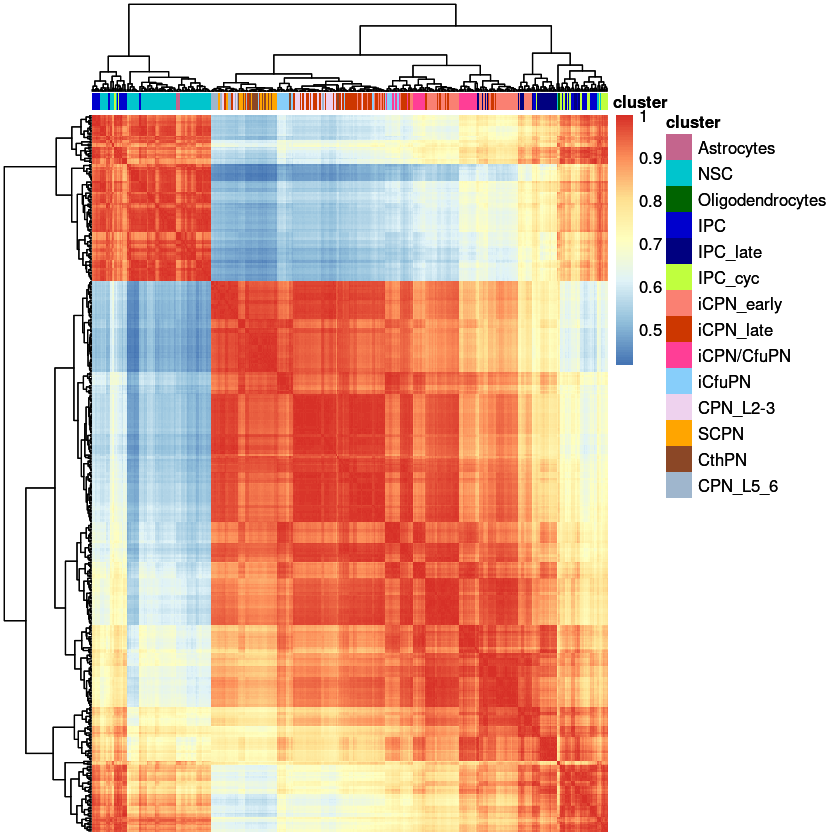

In [157]:
plot_atac_atac_cor(mcatac)

In [160]:
getwd()

[1] "/net/mraid14/export/tgdata/users/yonshap/proj/mmcortex"

### Test plot ATAC-RNA

In [202]:
devtools::load_all('~/src/mcATAC/')

ℹ Loading mcATAC



In [168]:
scdb_init('./scdb')

ERROR: Error in scdb_init("./scdb"): scdb already init to ./scdb use force reinit to restart it


In [169]:
mc = scdb_mc('pl_cort')

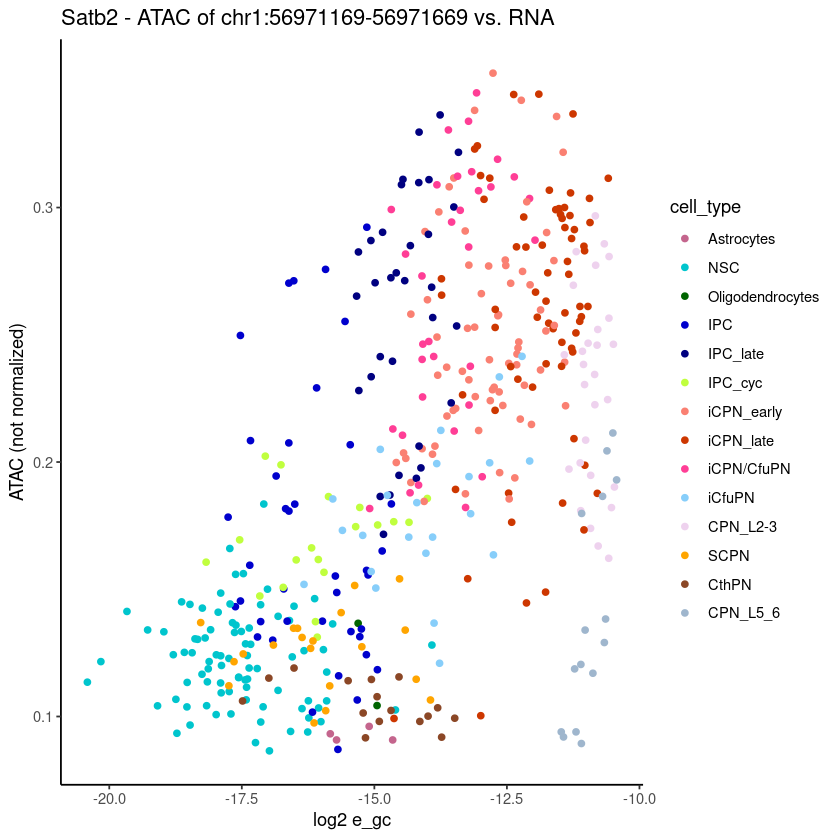

In [203]:
plot_atac_rna(mcatac, mc, 'Satb2')